In [1]:
import matplotlib.pyplot as plt

In [2]:
import pickle

In [3]:
import numpy as np

In [121]:
box = 'Box_n50_0_1400'

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()
M_numerics = np.logspace(11, 16, 50)
N_data = {}
M_data = {}
aux_data = {}


vol = -1 #Mpc^3/h^3
Mpart = -1

for a in (NvMs):
    c_data = NvMs[a]
    
    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))
    

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]
jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

print(jackknife.keys())

jack_covs = {a:jackknife[a][1] for a in N_data}

# Inverse of the weighted covariance matrix
inv_weighted_cov = {a:np.linalg.inv(jack_covs[a]) for a in jack_covs}  

scale_cov = {a:np.log(np.linalg.det(jack_covs[a])) for a in jack_covs}

dict_keys([0.302679, 0.366459, 0.403224, 0.488191, 0.512095, 0.537169, 0.563471, 0.591061, 0.620002, 0.65036, 0.715608, 0.787402, 0.866399, 0.953321, 1.0])


In [147]:
import matplotlib.colors as mcolors
plt.rcParams['axes.linewidth'] = 0.2
plt.rcParams['axes.linewidth'] = 0.2

plt.show()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

plt.rcParams['font.size'] = 11
# import seaborn as sns

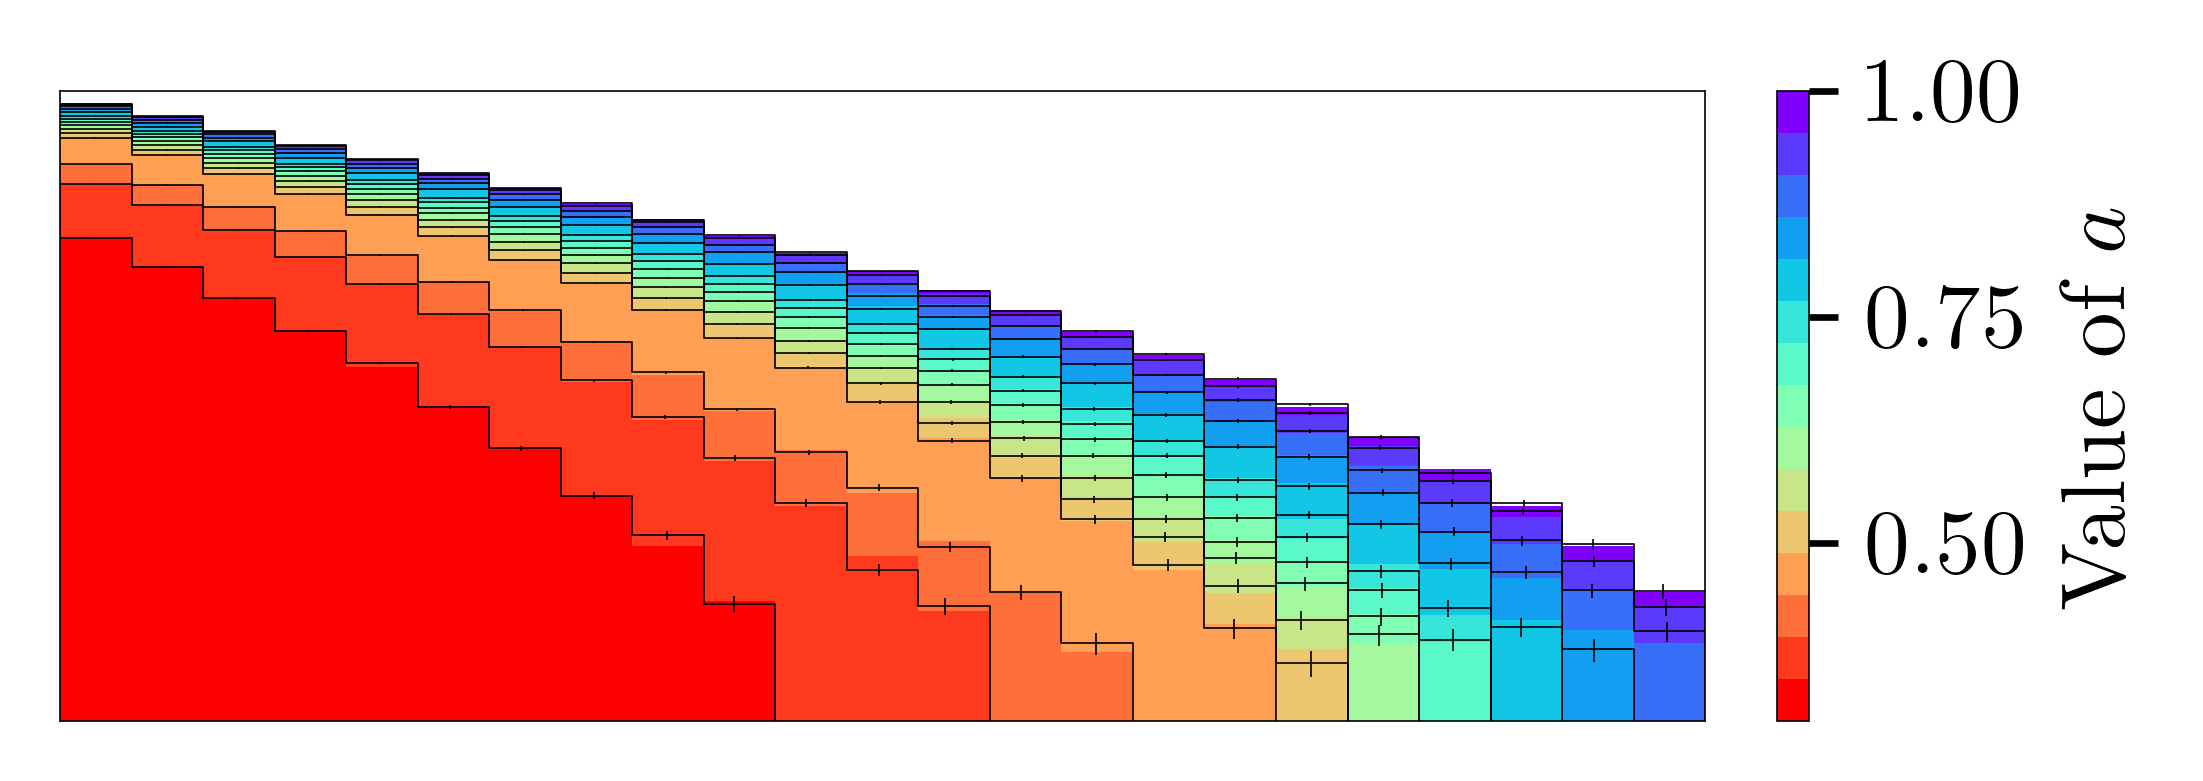

In [153]:
yerr_dict = {a:np.sqrt(np.diagonal(jack_covs[a])) for a in jack_covs} 
fig1 = plt.figure(figsize =(3, 3.5/2), dpi=600)

axs=[fig1.add_axes((0.0,0.4,1,.6))]#, fig1.add_axes((0.0,0.0,1,.4))]
plt.subplots_adjust(wspace=0, hspace=0)
offset = 0.01
color = []

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

rainbow = plt.colormaps['rainbow'].resampled(len(jack_covs.keys()))

rainbow_list = [mcolors.rgb2hex(rainbow(i)) for i in range(rainbow.N)]
# rainbow_list = rainbow_list[::-1]


for i,a in enumerate(reversed(jack_covs)):
    c_data = NvMs[a]
    N = N_data[a]

    
    
    Ms = np.array(M_data[a])
    
    edge_pairs = c_data['edge_pairs']
    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]
#     edges = np.array(edges)
#     tmp = [l*np.exp(offset*i)-l for l in edges]
#     edges += np.array(tmp)

    yerr = yerr_dict[a]

    fit_eval = None
    
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_NvMfit_output.pkl"%(box, a), "rb") as f:
        asdf = pickle.load(f)
        fit_eval = asdf['tinker_eval']

#     print(Ms.shape)
#     print(len(N))
#     axs[0].errorbar(Ms, N, yerr, fmt='+', c='black')

    #remove adaptive bin for clarity
    edges = edges[:-1]
    Ms = Ms[:-1]
    fit_eval = fit_eval[:-1]
    N = N[:-1]
    yerr = yerr[:-1]
    
    
    axs[0].bar(x=edges[:-1], height=fit_eval, width=np.diff(edges), align='edge', 
               fill=True, ec=None, fc=rainbow_list[i], rasterized=True)
    axs[0].step(edges+[edges[-1]],N+[N[-1]]+[0], 'k',where="post",linewidth=0.2)
    axs[0].errorbar(Ms, N, yerr, fmt='none', lw=0.2, c='black')

    

    y1 = 0.1*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.1*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    c_Ms = np.append(Ms, edges[-1])
    c_Ms = np.append(edges[0], c_Ms)
#     axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

    y1 = 0.01*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.01*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

#     axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


    axs[0].set_xscale('log')
    axs[0].set_yscale('log')

#     axs[1].set_xscale('log')
#     axs[1].axhline(0, c='black')
#     axs[1].set_xlabel(r'')
#     axs[1].set_ylabel(r'')
    axs[0].set_ylim(10, 2e5)
    left = np.ceil(np.log10(200*Mpart) * 10) / 10
    
    if(i==0):
        axs[0].set_xlim((10**left, np.max(edges[:-1])))
#         axs[1].set_xlim((10**left, np.max(edges[:-1])))
    
    
#     axs[1].set_ylim((-.29, .29))
#     axs[1].set_yticks([])
#     axs[1].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_xticks([])

    

# Assuming 'a_values' is a list of your 'a' values that you want to map to the colorbar
a_values = sorted(jack_covs.keys(), reverse=True)  # Replace with the actual list of 'a' values if necessary
norm = mcolors.Normalize(vmin=min(a_values), vmax=max(a_values))
sm = plt.cm.ScalarMappable(cmap=rainbow.reversed(), norm=norm)
sm.set_array([])  # You can set an empty array since the values are set through the normalization

# Add the colorbar to the figure
cbar = fig1.colorbar(sm, ax=axs, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Value of $a$')  # Set the label for the colorbar

plt.savefig('illustrative_figure.pdf', bbox_inches='tight')

In [154]:
from aemulusnu_massfunction import utils

In [ ]:
utils.scaleToRedshift()